In [1]:
import sys
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import math

# Adjust the path for c2qa and bosonic-qiskit modules
module_path = os.path.abspath(os.path.join('..', '..', '..'))  # Moves three directories up
if module_path not in sys.path:
    sys.path.append(module_path)

# Add the `playground` directory to the Python path
playground_path = Path.cwd().parent.parent  # Move two levels up to `playground`
if str(playground_path) not in sys.path:
    sys.path.append(str(playground_path))


# Qiskit and related imports
import qiskit
from qiskit.quantum_info import state_fidelity, Statevector, SparsePauliOp, Operator
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate, UnitaryGate
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import SLSQP
from qiskit.circuit.library import TwoLocal
from qiskit.primitives import Estimator

# Project-specific imports
import c2qa
import c2qa.util as util

import qutip as qt
import warnings
from scipy.optimize import minimize
from scipy.sparse import SparseEfficiencyWarning

### Exact Diagonalisation

In [2]:
def onsite_boson_term(n_sites = 2, omega = 1, N_b = 7):
    """
    Constructs the onsite boson term
    """
    d_b = N_b + 1 #cutoff + 1

    b = qt.destroy(d_b)   # annihilation operator 
    number_op = b.dag() * b   # number operator
    I = qt.qeye(d_b)             

    # Initialize the total term
    H_boson = 0

    for i in range(n_sites):
        # list of operators where the i-th entry is the number operator,
        # and all other entries are the identity.
        op_list = [number_op if j == i else I for j in range(n_sites)]
        H_i = qt.tensor(*op_list)
        H_boson += H_i

    H_boson = omega * H_boson

    return H_boson


def interaction_term(n_sites = 2, omega = 1, g = 1, N_b= 7):
    """
    """
    d_f = 2            # two-level system per site (empty/occupied)
    d_b = N_b + 1      # bosonic cutoff + 1
    I_f = qt.qeye(d_f)
    I_b = qt.qeye(d_b)

    # Fermionic number operator: n = |1><1|
    n_local = qt.Qobj([[0, 0],
                       [0, 1]])
    
    # Bosonic operators for single mode
    b = qt.destroy(d_b)
    b_dag = b.dag()
    disp_b = b + b_dag  

    # Initialize the total term
    H_total = 0
    
    for i in range(n_sites):
        fermion_op_list = [I_f for _ in range(n_sites)]
        fermion_op_list[i] = n_local
        H_f_i = qt.tensor(*fermion_op_list)
        
        # Build the bosonic displacement operator for site i
        boson_disp_list = [I_b for _ in range(n_sites)]
        boson_disp_list[i] = disp_b
        H_disp_i = qt.tensor(*boson_disp_list)
        
        H_int_i = g * omega * qt.tensor(H_f_i, H_disp_i)
        
        # Add this site's contribution
        H_total += H_int_i
        
    return H_total

def fermionic_hopping_term(n_sites = 2, V = 1):
    """
    Constructs the fermionic hopping term:
    """
    I = qt.qeye(2)
    sigmaz = qt.sigmaz()

    fermion_ops = []
    for i in range(n_sites):
        op_list = []
        for j in range(n_sites):
            if j < i:
                op_list.append(sigmaz)      # Jordan-Wigner string
            elif j == i:
                op_list.append(qt.destroy(2))  # Local annihilation operator
            else:
                op_list.append(I)
        f_i = qt.tensor(*op_list)
        fermion_ops.append(f_i)

    # Now sum the nearest-neighbor hopping terms with periodic boundary conditions
    H_hop = 0
    for i in range(n_sites):
        j = (i + 1) % n_sites
        H_hop += -V * (fermion_ops[i].dag() * fermion_ops[j] + fermion_ops[j].dag() * fermion_ops[i])
    
    return H_hop


def build_full_hamiltonian(n_sites=2, N_b=7, omega=1, g=1, V=1):
    """
    Constructs the full Hamiltonian for a system with n_sites fermionic and bosonic sites.

    """
    # Generate the individual Hamiltonian terms with n_sites
    int_term   = interaction_term(n_sites=n_sites, omega=omega, g=g, N_b=N_b)
    hop_term   = fermionic_hopping_term(n_sites=n_sites, V=V)
    onsite_term = onsite_boson_term(n_sites=n_sites, omega=omega, N_b=N_b)
    
    # Embed the fermionic hopping term into the full Hilbert space.
    boson_identities = [qt.qeye(N_b+1) for _ in range(n_sites)]
    full_hop = qt.tensor(hop_term, *boson_identities)
    
    # Embed the onsite boson term into the full Hilbert space.
    fermion_identities = [qt.qeye(2) for _ in range(n_sites)]
    full_onsite = qt.tensor(*fermion_identities, onsite_term)
    
    # full Hamiltonian
    H_full = full_hop + full_onsite + int_term

    return H_full

In [3]:
import scipy.sparse as sp
from scipy.sparse.linalg import eigsh

# build_full_hamiltonian  returns a Qobj
H_qutip = build_full_hamiltonian(n_sites=2, N_b=3, omega=1, g=0.5, V=1)
H_dense = H_qutip.full()  # Convert to a full dense numpy array
H_sparse = sp.csr_matrix(H_dense)  # Convert to sparse format
eigenvalues, eigenstates = eigsh(H_sparse, k=1, which='SA')

print("\nLowest eigenvalue:")
print(eigenvalues)

# print("\n Corresponding Eigenstate")
# print(eigenstates)


Lowest eigenvalue:
[-2.15048182]


# VQE

### Hybrid qubit-oscillator VQE
Although we don't expect to use the VQE for state prep in the fault tolerant era, we can do a brief comparison to highlight the potential of the hybrid qubit-oscillator architecture. We follow the method for the $Z_2$ Higgs model in Sec.VI.C.1 [here](https://arxiv.org/pdf/2409.03747) for ansatz construction:

VQE is a variational ansatz method used to approximate the ground state wavefunction. In this approach, multiple layers of unitary operators, $ U_i $, are applied to an initial state. For our two-site Holstein model, the Hamiltonian is given by

$$
\begin{aligned}
\hat{H} &= -V \Bigl( f_1^\dagger f_2 + f_2^\dagger f_1 \Bigr) \\
&\quad + \omega \Bigl( b_1^\dagger b_1 + b_2^\dagger b_2 \Bigr) \\
&\quad + g\,\omega \Bigl[ f_1^\dagger f_1\,\bigl(b_1^\dagger + b_1\bigr) + f_2^\dagger f_2\,\bigl(b_2^\dagger + b_2\bigr) \Bigr].
\end{aligned}
$$

We construct each unitary layer as

$$
U_i(\theta) = e^{i \theta h_k},
$$

where the Hamiltonian is decomposed into individual terms, i.e.,$\hat{H} = \sum_k h_k.$ As detailed in our Trotter circuits, we the unitaries $U_i$ correspond to the two qubit fsim gate, oscillator phase rotations, displacements and controlled displacements. We can use this as our ansatz.


In [4]:
def hopping_term(theta):
    """
    Create an fSim gate defined as U(t)=exp(i Vt/2 (XX+YY)).
    """
    
    U = np.array([
        [1,               0,               0, 0],
        [0,  np.cos(theta), -1j * np.sin(theta), 0],
        [0, -1j * np.sin(theta),  np.cos(theta), 0],
        [0,               0,               0, 1]
    ])
    return UnitaryGate(U, label="fSim")

def create_quantum_circuit(num_sites=2, num_qubits_per_qumode=3):
    """Create and initialize the circuit"""
    # Create registers
    qmr = c2qa.QumodeRegister(num_qumodes=num_sites, 
                             num_qubits_per_qumode=num_qubits_per_qumode)
    qbr = qiskit.QuantumRegister(num_sites)
    circuit = c2qa.CVCircuit(qmr, qbr)

    # initial state
    circuit.initialize([0, 1/np.sqrt(2), 1/np.sqrt(2), 0], qbr)
    return circuit, qmr, qbr

def ansatz(circuit, qmr, qbr, thetas, layers, noise):
    """
    Apply the ansatz using a distinct set of 7 parameters per layer.
    """
    cv_c_d_gatetime = 10  # in ns
    n_params = 7  # number of parameters per layer
    
    # check that we have the correct number of parameters.
    assert len(thetas) == layers * n_params, f"Expected {layers * n_params} parameters, got {len(thetas)}."
    
    for i in range(layers):
        offset = i * n_params
        # Hopping term
        fsim_gate = hopping_term(thetas[offset])
        circuit.append(fsim_gate, [qbr[0], qbr[1]])
        
        # Onsite boson potential
        circuit.cv_r(thetas[offset + 1], qmr[0])
        circuit.cv_r(thetas[offset + 2], qmr[1])
        
        # Coupling term
        circuit.cv_c_d(
            thetas[offset + 3],
            qmr[0],
            qbr[0],
            duration=cv_c_d_gatetime if noise else None,
            unit="ns" if noise else None
        )
        circuit.cv_d(thetas[offset + 4], qmr[0])
        circuit.cv_c_d(
            thetas[offset + 5],
            qmr[1],
            qbr[1],
            duration=cv_c_d_gatetime if noise else None,
            unit="ns" if noise else None
        )
        circuit.cv_d(thetas[offset + 6], qmr[1])
    
    return circuit

def run_simulation(circuit, noise=False, shots=10):
    """Run with or without noise."""
    if noise:
        photon_loss_rate = 1e-5 #in 1/ns
        # Add photon loss noise
        noise_pass = c2qa.kraus.PhotonLossNoisePass(
            photon_loss_rates=photon_loss_rate, circuit=circuit, time_unit="ns"
        )
        # Run  with noise
        states, _, _ = c2qa.util.simulate(
            circuit, shots=shots, per_shot_state_vector=True,
            return_fockcounts=False, noise_passes=noise_pass
        )
        # states will be a list of state vectors, one for each shot
        return states, True  # a flag indicating it's a list
    else:
        # Run the simulation without noise
        state, _, _ = c2qa.util.simulate(circuit)
        return state, False  # flag indicating it's not a list
    

def process_state(state_data, num_qubits_per_qumode):
    """
    Converts qiskit statevector(s) into a qutip Qobj 
    for easier comparisons
    """
    state, is_list = state_data
    
    # Function for a single statevector
    def process_single_state(single_state):
        dims = [[2, 2, 2**num_qubits_per_qumode, 2**num_qubits_per_qumode], [1, 1, 1, 1]]
        state_qobj = qt.Qobj(single_state, dims=dims)
        
        d_b = 2**num_qubits_per_qumode
        S_bos = 0
        for i in range(d_b):
            for j in range(d_b):
                ket = qt.tensor(qt.basis(d_b, j), qt.basis(d_b, i))
                bra = qt.tensor(qt.basis(d_b, i), qt.basis(d_b, j)).dag()
                S_bos += ket * bra
        
        I_ferm = qt.tensor(qt.qeye(2), qt.qeye(2))
        P = qt.tensor(I_ferm, S_bos)
        return P * state_qobj
    
    # If we have a list of states, do each one
    if is_list:
        return [process_single_state(s) for s in state]
    else:
        return process_single_state(state)

In [5]:
def run_and_compute_expectation(thetas, layers, noise=False, shots=10, num_qubits_per_qumode=3):
    """
    Create the circuit, apply the ansatz, run the simulation, process the state,
    and compute & return the expectation value with respect to exact H.

    """
    circuit, qmr, qbr = create_quantum_circuit(num_sites=2, num_qubits_per_qumode=num_qubits_per_qumode)
    
    circuit = ansatz(circuit, qmr, qbr, thetas, layers, noise)
    
    state_data = run_simulation(circuit, noise=noise, shots=shots)
    
    processed_state = process_state(state_data, num_qubits_per_qumode)
    
    H_qutip = build_full_hamiltonian(n_sites=2, N_b=2**num_qubits_per_qumode - 1, omega=1, g=1, V=1)
    if isinstance(processed_state, list):
        expectation_values = [qt.expect(H_qutip, state) for state in processed_state]
    else:
        expectation_values = qt.expect(H_qutip, processed_state)
    
    return expectation_values

from scipy.optimize import minimize

def optimize_vqe(initial_thetas, layers=1, num_qubits_per_qumode=3):
    """
    Optimize VQE using SLSQP and track the energy at each iteration
    """
    energy_trace = []
    
    def objective(thetas):
        energy = run_and_compute_expectation(
            thetas, layers, noise=False, shots=1, num_qubits_per_qumode=num_qubits_per_qumode
        )
        return energy

    def callback(xk):
        # Record the energy at the end of each iteration
        energy = run_and_compute_expectation(
            xk, layers, noise=False, shots=1, num_qubits_per_qumode=num_qubits_per_qumode
        )
        energy_trace.append(energy)
    
    result = minimize(objective, initial_thetas, method='SLSQP', 
                      options={'disp': True}, callback=callback)
    return result, energy_trace


In [6]:
warnings.filterwarnings("ignore", category=SparseEfficiencyWarning)
num_qubits_per_qumode = 2

### Exact
H_qutip = build_full_hamiltonian(n_sites=2, N_b=2**num_qubits_per_qumode-1, omega=1, g=1, V=1)
H_dense = H_qutip.full()
H_sparse = sp.csr_matrix(H_dense)
eigenvalues, eigenstates = eigsh(H_sparse, k=1, which='SA')
E0 = eigenvalues[0]
print("Exact ground-state energy, E0 =", E0)

#Compare for 1, 2, 3 layers
layers_list = [1, 2, 3]
energy_traces = {}  

for layers in layers_list:
    n_params = 7 * layers  # 7 parameters per layer
    initial_thetas = []
    
    # Base guess for each layer [hopping, cv_r1, cv_r2, cv_c_d, cv_d1, cv_c_d2, cv_d2]
    base_guess = np.array([0.8, 1.0, 1.0, 0.3, -0.6, 0.3, -0.6])
    
    for layer in range(layers):
        # add a variation for parameters for extra layers
        variation = np.random.uniform(-0.05, 0.05, size=base_guess.shape)
        layer_params = base_guess + variation
        initial_thetas.extend(layer_params.tolist())
    
    initial_thetas = np.array(initial_thetas)

    print(f"\nOptimizing for {layers} layer(s) with {n_params} parameters:")
    result, energy_trace = optimize_vqe(initial_thetas, layers=layers, num_qubits_per_qumode=num_qubits_per_qumode)
    
    # |E_VQE - E0|/|E0|
    rel_errors = [abs(energy - E0)/abs(E0) for energy in energy_trace]
    energy_traces[layers] = rel_errors
    
    final_rel_error = abs(result.fun - E0)/abs(E0)
    print(f"Final optimized energy: {result.fun}")
    print(f"Final relative error: {final_rel_error}")


Exact ground-state energy, E0 = -2.6031252581053916

Optimizing for 1 layer(s) with 7 parameters:
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2.5976813171090956
            Iterations: 8
            Function evaluations: 69
            Gradient evaluations: 8
Final optimized energy: -2.5976813171090956
Final relative error: 0.0020913096591664952

Optimizing for 2 layer(s) with 14 parameters:
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2.5976812524070274
            Iterations: 10
            Function evaluations: 157
            Gradient evaluations: 10
Final optimized energy: -2.5976812524070274
Final relative error: 0.002091334514700414

Optimizing for 3 layer(s) with 21 parameters:
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2.600527992503554
            Iterations: 34
            Function evaluations: 760
            Gradient evaluations: 34
F

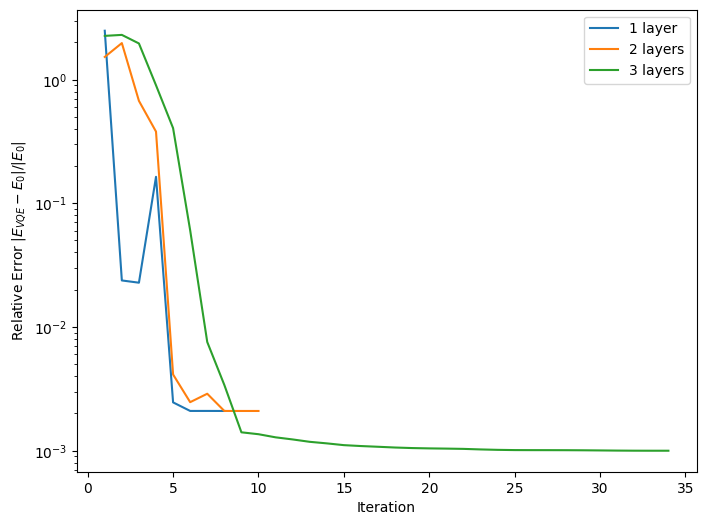

In [7]:
plt.figure(figsize=(8, 6))
for layers, rel_errors in energy_traces.items():
    iterations = np.arange(1, len(rel_errors) + 1)
    plt.plot(iterations, rel_errors, marker='None', label=f"{layers} layer{'s' if layers>1 else ''}")

plt.xlabel("Iteration")
plt.ylabel(r"Relative Error $|E_{VQE}-E_0|/|E_0|$")
# plt.title("Relative Error vs. Iterations for Different Ansatz Layers")
plt.legend()
plt.yscale("log")
plt.show()


### All Qubit VQE
Boson gates are extremely expensive to constructt on qubit hardware. Thus we have to take a different choice on ansatz

In [8]:
num_qubits_per_boson = 2         # cutoff: 2**2 - 1
boson_qubits = 2 * num_qubits_per_boson  # for 2 sites
fermion_qubits = 2               # for 2 sites
num_qubits = 2 + 2 * boson_qubits

# ansatz and optimizer
qubit_ansatz = TwoLocal(num_qubits, "ry", "cz")
optimizer = SLSQP(maxiter=1000)

estimator = Estimator()
energy_trace = []

def vqe_callback(nfev, parameters, mean, std):
    """Callback to record energy mean at each evaluation."""
    energy_trace.append(mean)

vqe = VQE(estimator, qubit_ansatz, optimizer, callback=vqe_callback)

H_qutip = build_full_hamiltonian(n_sites=2, 
                                 N_b=2**num_qubits_per_boson - 1, 
                                 omega=1, g=1, V=1).full()
H = SparsePauliOp.from_operator(Operator(H_qutip))

# exact diago for reference ---
H_sparse = sp.csr_matrix(H_qutip)
eigenvalue, _ = eigsh(H_sparse, k=1, which="SA")
print("Exact ground-state energy, E0 =", eigenvalue)

result = vqe.compute_minimum_eigenvalue(H)
print("\nVQE Result:")
print(result)

/tmp/ipykernel_1838658/1101948096.py:10: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


Exact ground-state energy, E0 = [-2.60312526]



VQE Result:
{   'aux_operators_evaluated': None,
    'cost_function_evals': 1309,
    'eigenvalue': -2.5909908752027193,
    'optimal_circuit': <qiskit.circuit.library.n_local.two_local.TwoLocal object at 0x7f465067e220>,
    'optimal_parameters': {   ParameterVectorElement(θ[22]): -4.708902822639066,
                              ParameterVectorElement(θ[23]): 6.371739920340136,
                              ParameterVectorElement(θ[20]): -0.8444318689611359,
                              ParameterVectorElement(θ[21]): 4.964046777046019,
                              ParameterVectorElement(θ[17]): -6.395211610866645,
                              ParameterVectorElement(θ[3]): 4.779390329952361,
                              ParameterVectorElement(θ[1]): 6.2835744527251896,
                              ParameterVectorElement(θ[19]): -5.942480554926358,
                              ParameterVectorElement(θ[14]): -6.306146667807443,
                              ParameterVectorElement

In [9]:
# Decompose the ansatz to count gates
decomposed_ansatz = qubit_ansatz.decompose()
ops = decomposed_ansatz.count_ops()
print("Operations in the ansatz:", ops)

Operations in the ansatz: OrderedDict([('cz', 45), ('ry', 24)])


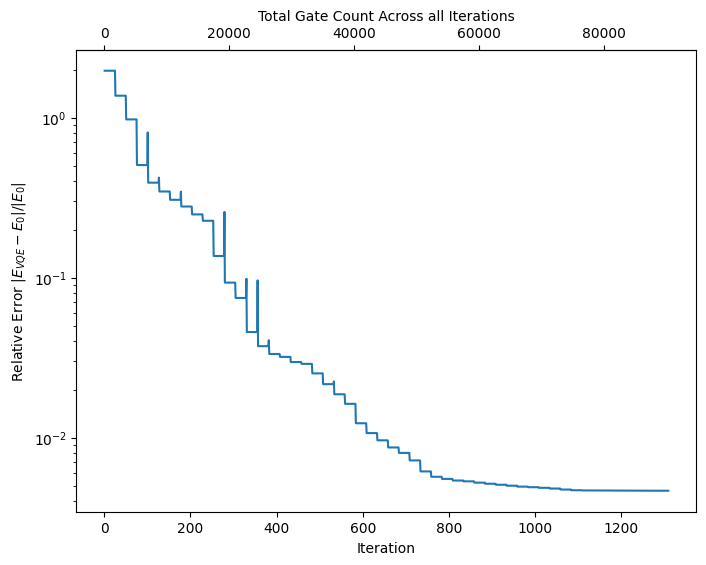

In [10]:
#  |E_VQE - E0| / |E0| again
rel_errors = [abs(energy - E0) / abs(E0) for energy in energy_trace]

plt.figure(figsize=(8, 6))
iterations = np.arange(1, len(rel_errors) + 1)
plt.plot(iterations, rel_errors, marker="None", linestyle="-")
plt.xlabel("Iteration")
plt.ylabel(r"Relative Error $|E_{VQE}-E_0|/|E_0|$")
plt.yscale("log")

# Add a secondary x-axis for total gates across all iterations
ax = plt.gca()
secax = ax.secondary_xaxis('top', functions=(lambda x: x * 69, lambda x: x / 69))
secax.set_xlabel("Total Gate Count Across all Iterations")

plt.show()

Using the VQE here is just an example—we don't aim to use VQE in the early fault-tolerant era, hence this comparison isn't comprehensive. Instead, this brief work demonstrates the potential in the depth and number of gates you can save by using native bosonic resources. To summarise, the hybrid qubit-oscillator circuit directly implements bosonic operators, which are naturally suited to the problem. Because bosonic operators are expensive to construct on qubit-only architectures, we choose a generic qubit ansatz `TwoLocal`. This isn't really an apples-to-apples comparison, but it serves as an indication of the resource efficiency of the hybrid architecture. 

In terms of performance, the hybrid qubit-oscillator ansatz achieves a relative error below $10^{-3}$ using 3 layers of the ansatz and 35 iterations. With $3 \times 7$ gates per iteration, that's $21 \times 35 = 735$ total gates across all iterations. In contrast, the qubit-only ansatz achieves around $3 \times 10^{-2}$ relative error using $\sim2500$ iterations and $69$ gates (cz's and ry's) per iteration, which amounts to $2500 \times 69 = 172500$ total gates across all iterations. Obviously, for a completely fair comparison, we would have to tailor the all qubit ansatz and so on, which is beyond our scope.



### Quantum Eigenvalue Transformation of Unitary Matrices
